# CSE519 Project: Dating Documents
## Tim Zhang (110746199)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
from time import time
from IPython.display import display
from bs4 import BeautifulSoup
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC

# Global settings
%matplotlib notebook
pd.set_option('display.max_rows', None)  

# Exploratory Analysis

## Corpus of Historical American English (COHA)
### Parsing

We will need to parse the COHA corpus into date labels and text.  The corpus is subdivided by sources as Fiction, Magazine, News, and Nonfiction.  It may prove useful to keep the categories of data sources disjoint.

The data files have an easily parsable format, where newlines delimit the examples $(x^{(i)}, y^{(i)})$ and the label is delimited with a tab.  We will store the data as a Pandas dataframe.

In [2]:
def parse_coha(filename):
    data = []
    
    with open('Data/COHA/' + filename, 'r') as f:
        samples = f.read().split('\n')[:-1]  # Ignore final newline
    
    for sample in samples:
        split = sample.split('\t')
        data.append((split[0], split[1]))

    # Save data into dataframe
    df = pd.DataFrame(data, columns=['Year', 'Text']).sort_values(['Year'])
    
    # Create Decade label
    df['Decade'] = df.apply(lambda row: int(str(row.Year)[:3] + '0'), axis=1)
    
    return df

Now we can parse each of the COHA categories into a dictionary.

In [3]:
sources = ['coha_fiction', 'coha_mag', 'coha_news', 'coha_nf']
coha_data = dict.fromkeys(sources, pd.DataFrame)

for source in sources:
    coha_data[source] = parse_coha(source + '.data')

Next we will concatenate each dataframe into the full dataset and add a new column for the length of the text.

In [40]:
coha_full = coha_data['coha_mag'].append(coha_data['coha_news']).append(coha_data['coha_fiction']).append(coha_data['coha_nf'])
coha_full.sort_values(['Year'], inplace=True)
coha_full.reset_index(drop=True, inplace=True)
coha_full['Length'] = coha_full.apply(lambda row: len(row.Text.split()), axis=1)

Finally, we will save the dataframe as a pkl object.

In [59]:
coha_full.to_pickle('coha_full.pkl')

In [64]:
coha_full = pd.read_pickle('coha_full.pkl')

### Analysis

Once we have our data parsed into dataframes, we should do some exploratory analysis.  For this we will investigate summary statistics of the full dataset at the year and decade resolutions with respect to the occurances of the labels.  Since there are almost 200 years represented in the dataset, we will output this data raw.

In [53]:
def analyze_coverage(counts):
    # Print summary statistics on coverage data
    print("    Max: %s" % (counts.max()))
    print("    Min: %s" % (counts.min()))
    print("    Mean: %s" % (counts.mean()))
    print("    Std: %s" % (counts.std()))
    print("    Median: %s" % (counts.median()))

In [54]:
def analyze_corpus_data(df):
    # Get year coverage data
    counts = pd.value_counts(df['Year']).sort_index()
    
    print "Year Coverage Statistics:"
    analyze_coverage(counts)

    print '\nComplete Year Distribution:'
    print counts.head(-1)
    print '\n'
    
    # Get decade coverate data
    decade_counts = pd.value_counts(df['Decade']).sort_index()
    print "Decade Coverage Statistics:"
    analyze_coverage(decade_counts)

    plt.figure()
    decade_counts.sort_index().plot(kind='barh', title="Number of Documents per Decade")
    print '\n'

Year Coverage Statistics:
    Max: 1278
    Min: 1
    Mean: 200.0
    Std: 212.749740919
    Median: 130.0

Complete Year Distribution:
1810       2
1811       4
1812       6
1813       1
1814       3
1815      11
1816       8
1817       9
1818       5
1819       7
1820      14
1821      20
1822      21
1823      21
1824      16
1825      13
1826      16
1827      39
1828      27
1829      37
1830      40
1831      25
1832      44
1833      55
1834      50
1835      67
1836      63
1837      44
1838      39
1839      60
1840      30
1841      30
1842      34
1843      45
1844      76
1845      69
1846      45
1847      58
1848      52
1849      65
1850      40
1851      41
1852      44
1853      55
1854      43
1855      61
1856      45
1857      35
1858      18
1859      48
1860      30
1861      45
1862      56
1863      54
1864      90
1865      49
1866      47
1867      41
1868      76
1869      68
1870      39
1871      75
1872      59
1873      76
1874      89
1875      94
1876 

<IPython.core.display.Javascript object>


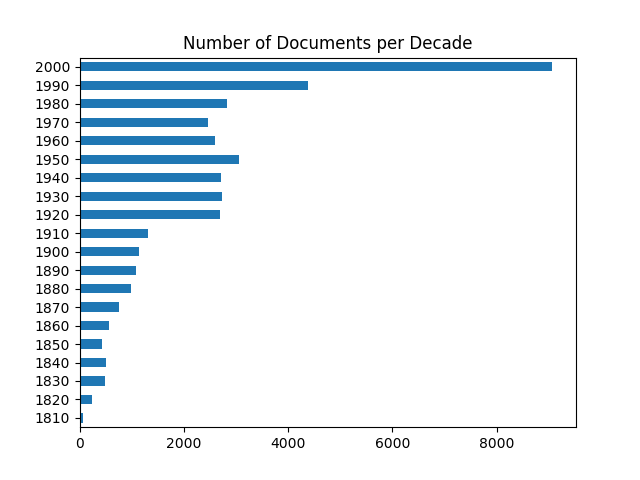

In [5]:
analyze_corpus_data(coha_full)

From the above analysis we see that the COHA dataset is not balanced with respect to year (or decade) representation.  As mentioned in my preliminary report, we should try to balance our classes for the best results.  As such we will need our other data sources to try and fill in the gaps.

Next let us investigate the size of the datasets (in tokens) at decade resolution.

In [55]:
def analyze_text(df):
    decades = df.groupby('Decade')['Length']
    print 'Text Frequency Statistics:'
    print("\nTotal:\n%s" % (decades.sum()))
    print("\nMax:\n%s" % (decades.max()))
    print("\nMin:\n%s" % (decades.min()))
    print("\nMean:\n%s" % (decades.mean()))
    print("\nStd:\n%s" % (decades.std()))
    print("\nMedian:\n%s" % (decades.median()))
    plt.figure()
    decades.sum().plot(kind='barh', title="Total Token Count per Decade")

Text Frequency Statistics:

Total:
Decade
1810     2866316
1820     9496850
1830    21853319
1840    23512631
1850    24376172
1860    19617488
1870    24253002
1880    25419490
1890    24617174
1900    26362711
1910    28253093
1920    25997854
1930    26737154
1940    25890449
1950    27062006
1960    25365215
1970    26211245
1980    30264682
1990    29758832
2000    30458993
Name: Length, dtype: int64

Max:
Decade
1810    227155
1820    160380
1830    252998
1840    364780
1850    251887
1860    255796
1870    213229
1880    191478
1890    200410
1900    240932
1910    210337
1920    213193
1930    245479
1940    213128
1950    207824
1960    176500
1970    302613
1980    294180
1990    141824
2000     60408
Name: Length, dtype: int64

Min:
Decade
1810    216
1820    197
1830    180
1840      1
1850      0
1860    188
1870      1
1880    152
1890     58
1900    149
1910    145
1920     43
1930     66
1940     33
1950     61
1960     60
1970     28
1980     14
1990      7
2000      

<IPython.core.display.Javascript object>


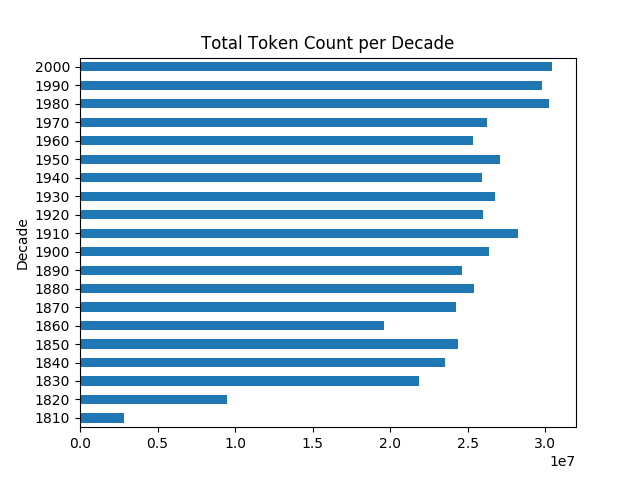

In [7]:
analyze_text(coha_full)

We can see that the amount of tokens per decade is relatively balanced.  This implies that while there are less documents for the earlier decades, each document has more text.  The summary statistics also indicate that this is the case.

# Evaluation Environment

First let us partition our training data into train and test splits, saving the results for convenience.

In [36]:
coha_train, coha_test = train_test_split(coha_full, test_size=0.2)
coha_train.to_pickle('coha_train.pkl')
coha_test.to_pickle('coha_test.pkl')

In [2]:
coha_train = pd.read_pickle('coha_train.pkl')
coha_test = pd.read_pickle('coha_test.pkl')

Next we will define our evaluation function which we will use to compare different models.

In [3]:
decades = [1810, 1820, 1830, 1840, 1850, 1860, 1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]

def eval_learner(y, pred):
    # Display confusion matrix
    df_cm = pd.DataFrame(confusion_matrix(y, pred), index = [i for i in decades], columns = [i for i in decades])
    plt.figure(figsize = (20,10))
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

    # Display metrics
    print(classification_report(y, pred, target_names=map(str, decades)))
    print('Accuracy: %s\n' % accuracy_score(y, pred))
    print('MAE: %s' % mean_absolute_error(y, pred))

## The Monkey

Next we will investigate how well the "monkey" does on our test set.

In [11]:
monkey_pred = [decades[i] for i in np.random.choice(20, len(coha_test))]

<IPython.core.display.Javascript object>


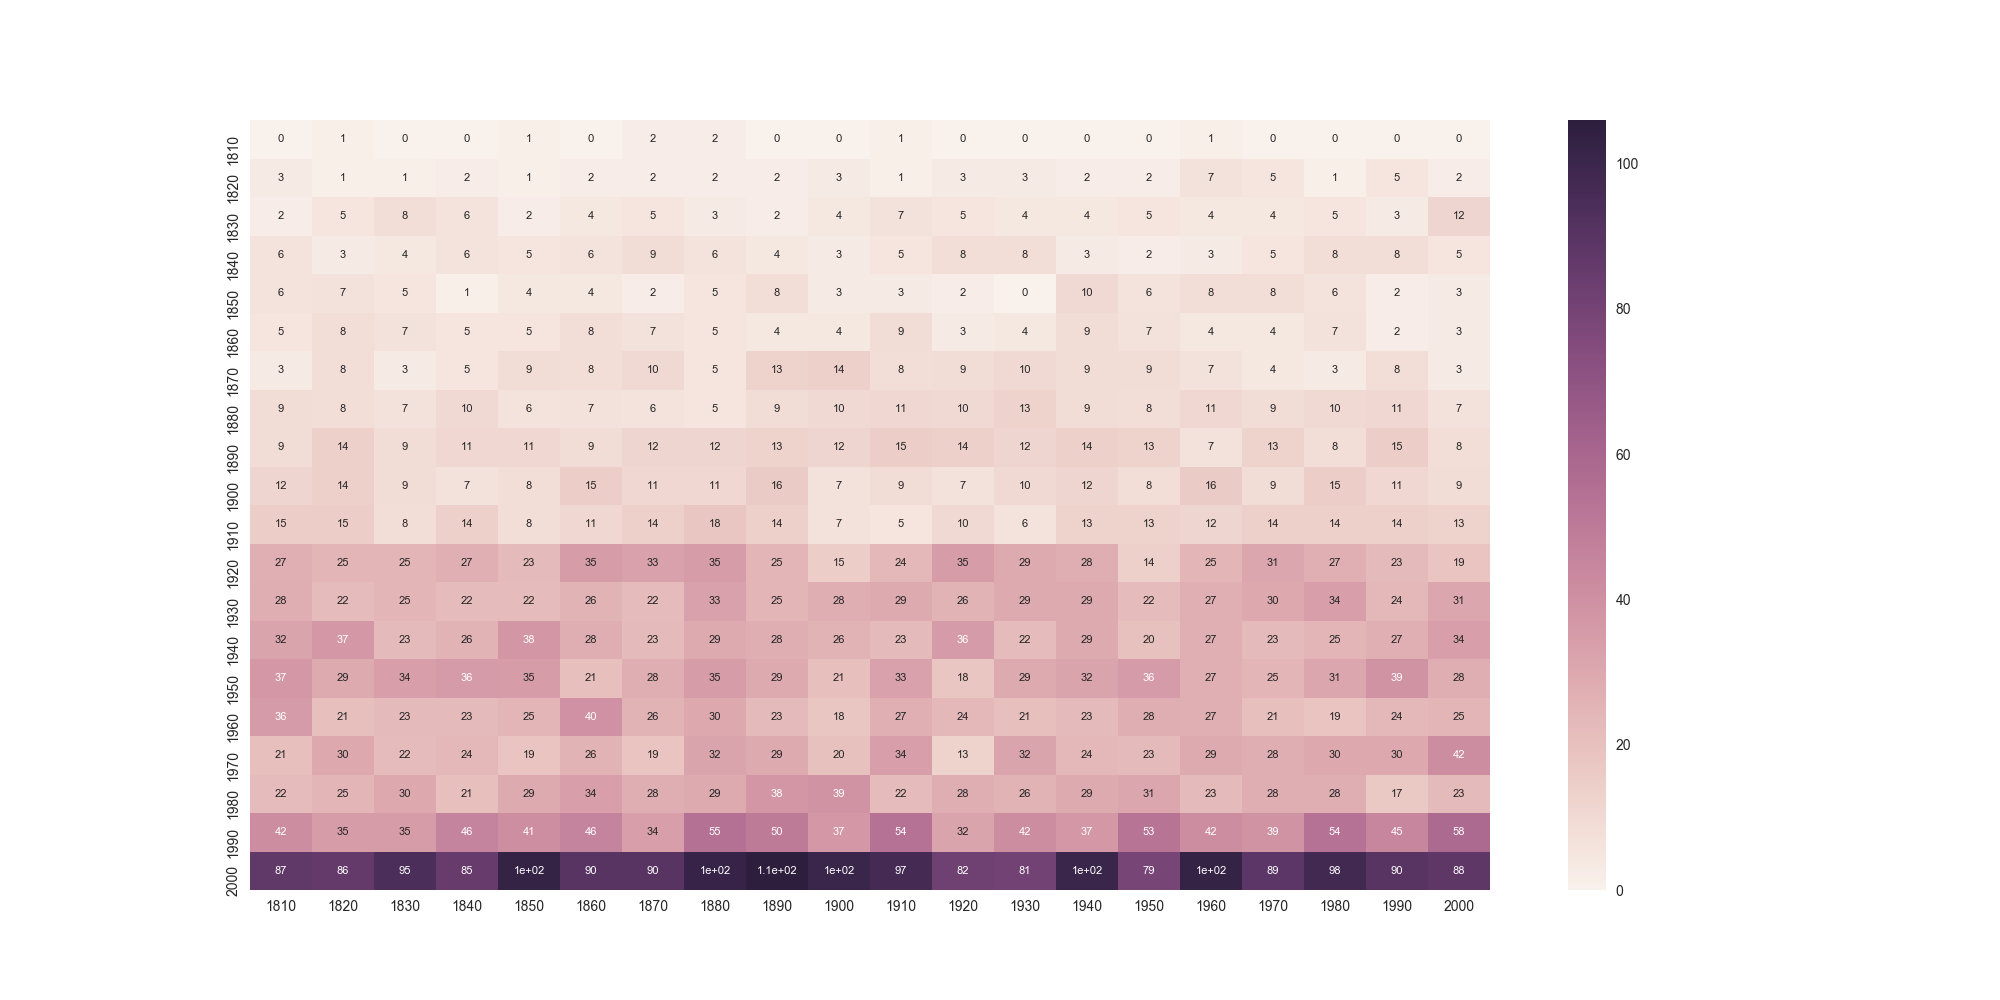

Accuracy: 0.0515

             precision    recall  f1-score   support

       1810       0.00      0.00      0.00         8
       1820       0.00      0.02      0.00        50
       1830       0.02      0.09      0.03        94
       1840       0.02      0.06      0.02       107
       1850       0.01      0.04      0.02        93
       1860       0.02      0.07      0.03       110
       1870       0.03      0.07      0.04       148
       1880       0.01      0.03      0.02       176
       1890       0.03      0.06      0.04       231
       1900       0.02      0.03      0.02       216
       1910       0.01      0.02      0.02       238
       1920       0.10      0.07      0.08       525
       1930       0.08      0.05      0.06       534
       1940       0.07      0.05      0.06       556
       1950       0.09      0.06      0.07       603
       1960       0.07      0.05      0.06       504
       1970       0.07      0.05      0.06       527
       1980       0.07     

In [30]:
eval_learner(coha_test['Decade'], monkey_pred)

We see that the test split has many more documents from 1990-2000 decades, which is unsurprising since the entire corpus follows this trend.  We also see that uniform choices will not lead to very high accuracy.

## Feature Extraction

For our learning algorithms we will need to process the raw text data into a numerical vector.  To achieve this we will use a Bag of Words model as a baseline.  We will later compare this naive approach to more sophisticated Bag of Ngrams.

In [5]:
vectorizer = CountVectorizer(stop_words='english')
transformer = TfidfTransformer()
X_train_counts = vectorizer.fit_transform(coha_train['Text'])
X_train = transformer.fit_transform(X_train_counts)

In [10]:
X_test_counts = vectorizer.transform(coha_test['Text'])
X_test = transformer.transform(X_test_counts)

Let's save our features for later use.

In [14]:
pickle.dump(X_train, open("coha_BoW_train.pkl", "wb"))
pickle.dump(X_test, open("coha_BoW_test.pkl", "wb"))

In [4]:
X_train = pickle.load(open("coha_BoW_train.pkl", "rb"))
X_test = pickle.load(open("coha_BoW_test.pkl", "rb"))

Next we will consider trigrams.

In [34]:
vectorizer_ng = HashingVectorizer(stop_words='english', ngram_range=(1, 3), non_negative=True)
transformer_ng = TfidfTransformer()
X_train_ngcounts = vectorizer_ng.transform(coha_train['Text'])
X_train_ng = transformer_ng.fit_transform(X_train_ngcounts)

1975.07061887


In [35]:
X_test_ngcounts = vectorizer_ng.transform(coha_test['Text'])
X_test_ng = transformer_ng.transform(X_test_ngcounts)

## Learning Algorithms

### Multinomial Naive Bayes

#### Unigram

In [24]:
MNB_clf = MultinomialNB().fit(X_train_counts, coha_train['Decade'])

In [25]:
MNB_pred = MNB_clf.predict(X_test_counts)

<IPython.core.display.Javascript object>


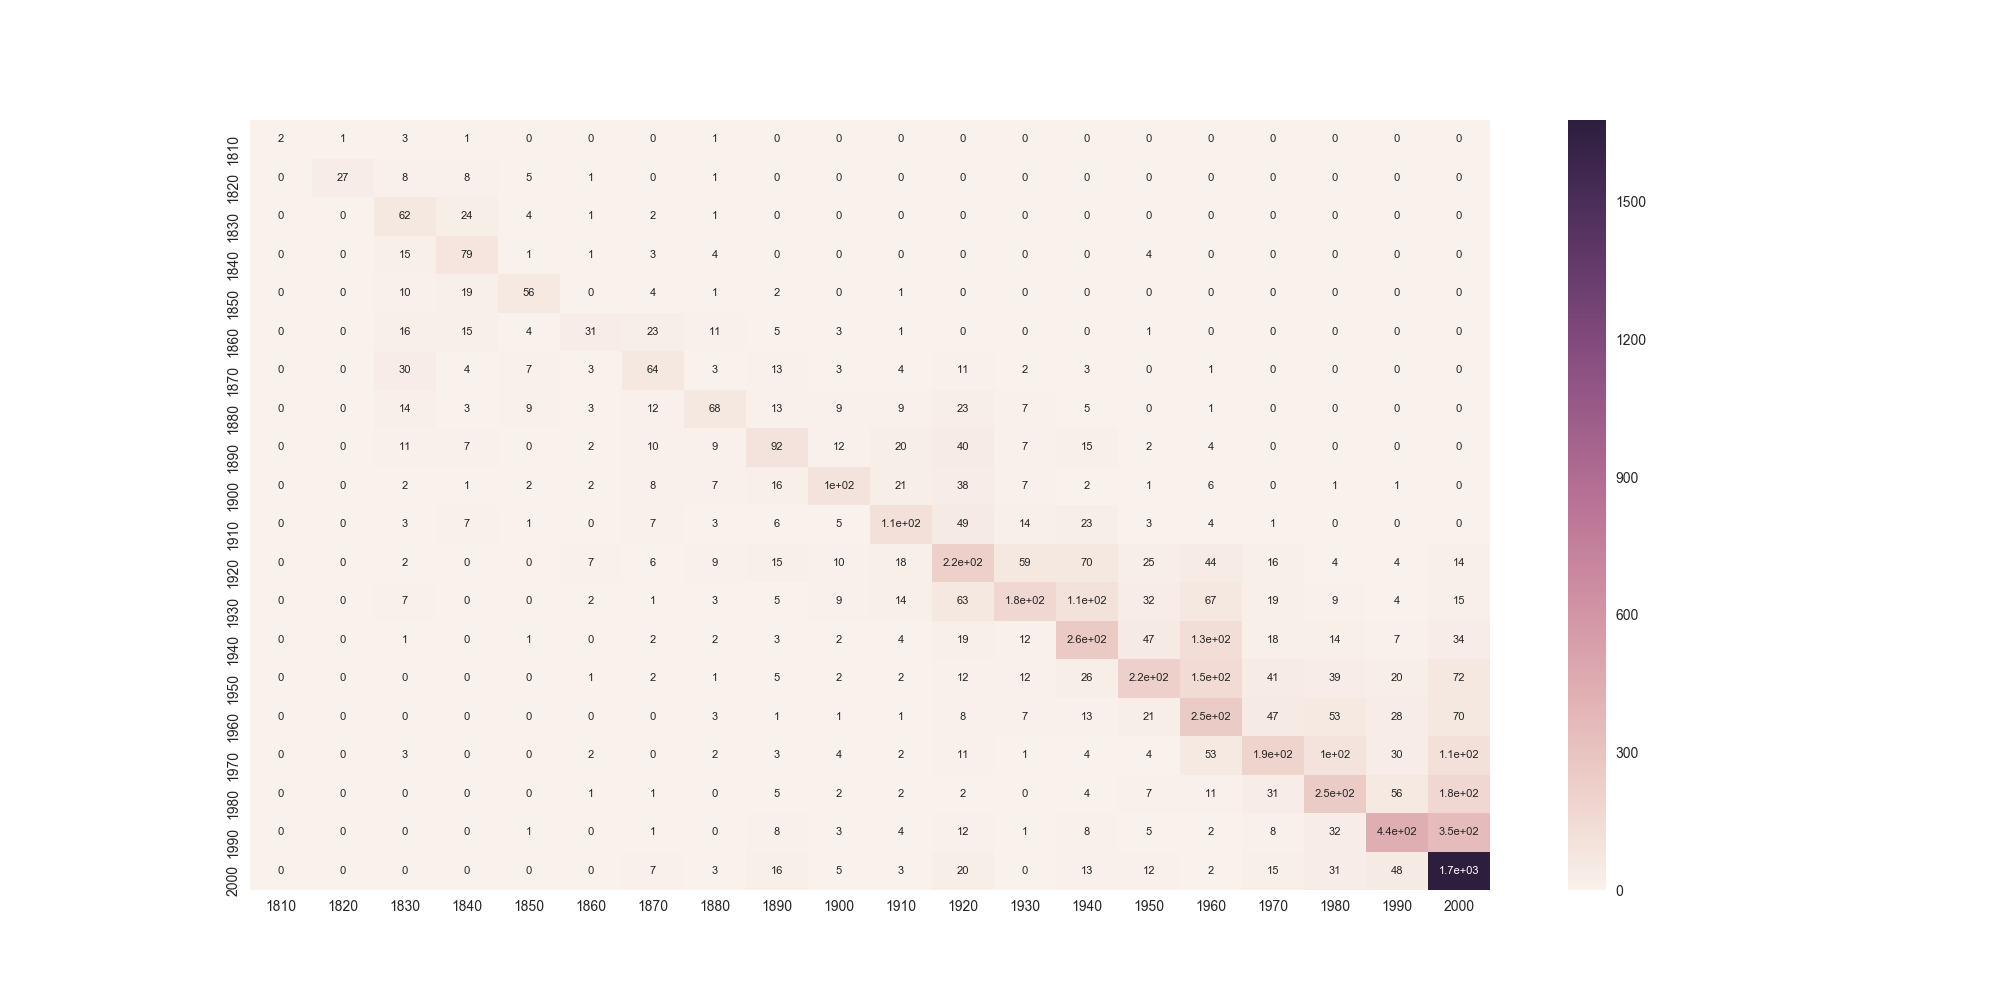

             precision    recall  f1-score   support

       1810       1.00      0.25      0.40         8
       1820       0.96      0.54      0.69        50
       1830       0.33      0.66      0.44        94
       1840       0.47      0.74      0.57       107
       1850       0.62      0.60      0.61        93
       1860       0.54      0.28      0.37       110
       1870       0.42      0.43      0.43       148
       1880       0.52      0.39      0.44       176
       1890       0.44      0.40      0.42       231
       1900       0.59      0.47      0.52       216
       1910       0.51      0.47      0.49       238
       1920       0.42      0.42      0.42       525
       1930       0.58      0.33      0.42       534
       1940       0.47      0.47      0.47       556
       1950       0.58      0.37      0.45       603
       1960       0.35      0.50      0.41       504
       1970       0.49      0.36      0.42       527
       1980       0.47      0.46      0.46   

In [26]:
eval_learner(coha_test['Decade'], MNB_pred)

#### Trigram

In [36]:
MNB_ngclf = MultinomialNB().fit(X_train_ngcounts, coha_train['Decade'])

In [37]:
MNB_ngpred = MNB_ngclf.predict(X_test_ngcounts)

<IPython.core.display.Javascript object>


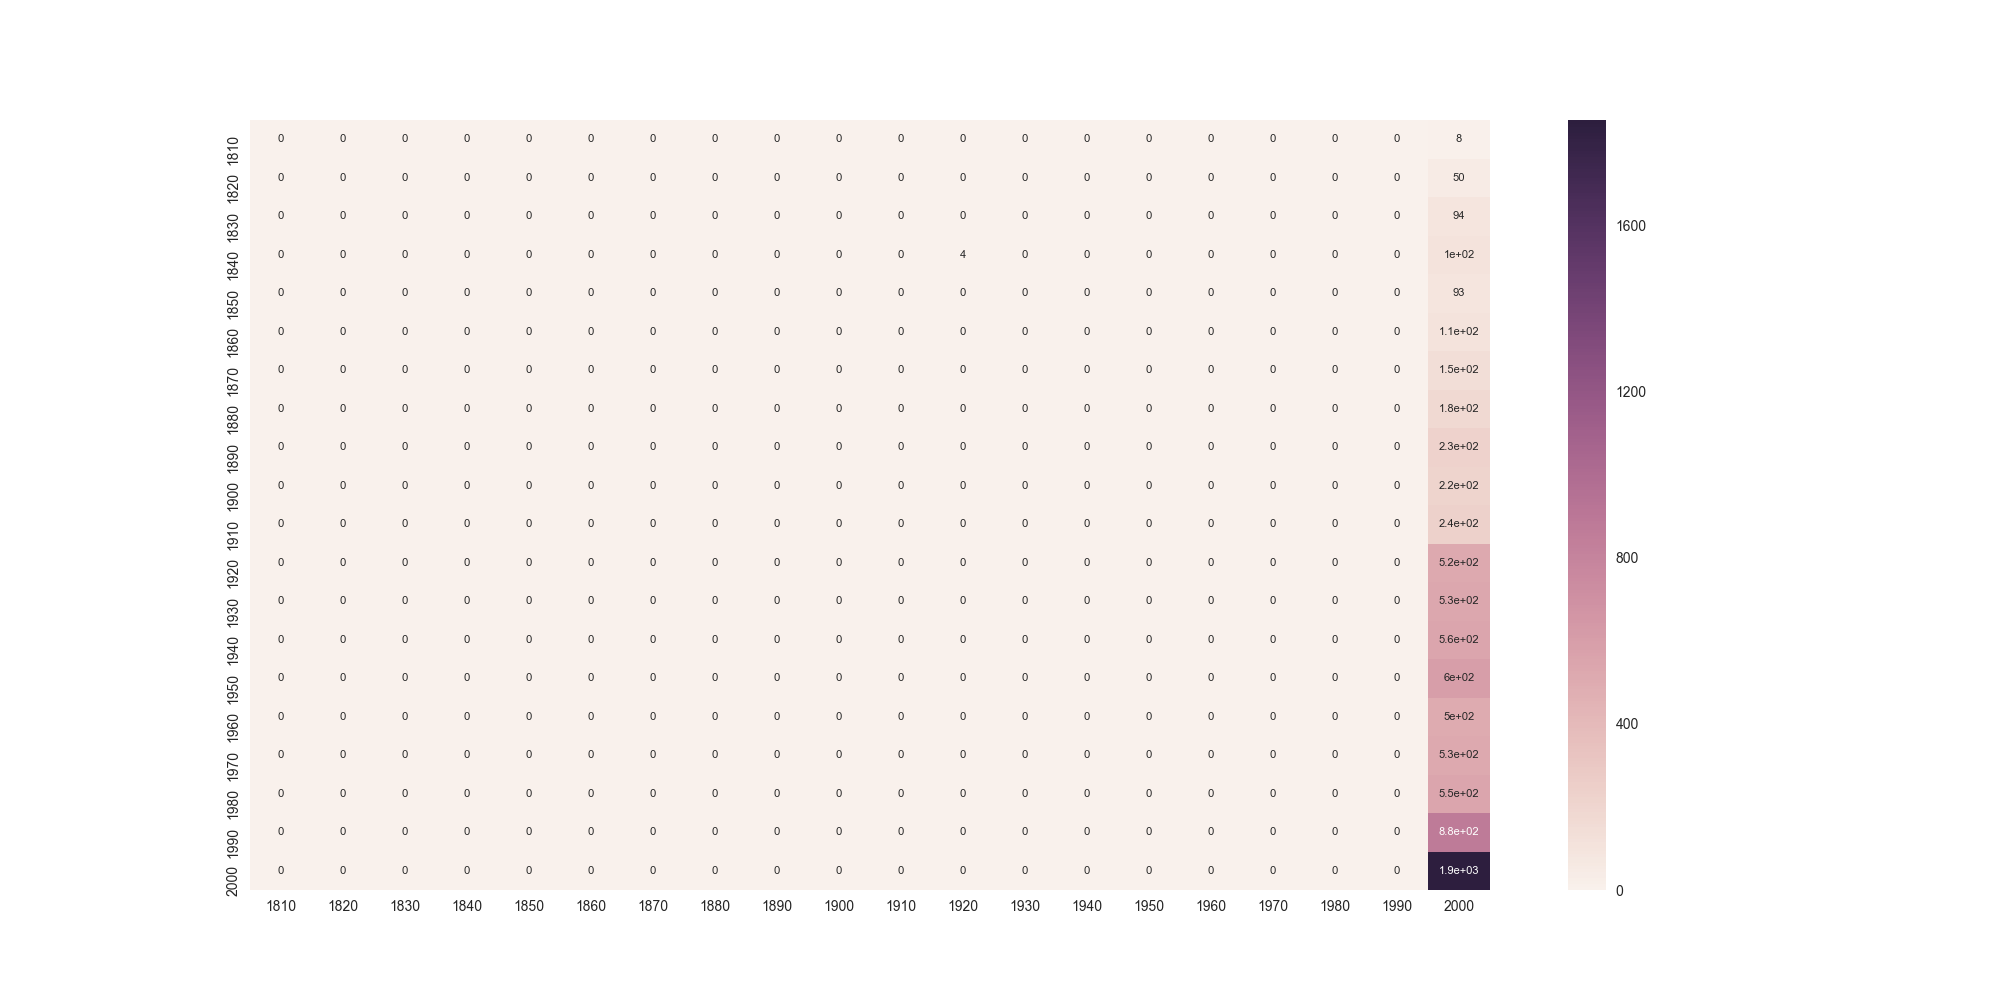

             precision    recall  f1-score   support

       1810       0.00      0.00      0.00         8
       1820       0.00      0.00      0.00        50
       1830       0.00      0.00      0.00        94
       1840       0.00      0.00      0.00       107
       1850       0.00      0.00      0.00        93
       1860       0.00      0.00      0.00       110
       1870       0.00      0.00      0.00       148
       1880       0.00      0.00      0.00       176
       1890       0.00      0.00      0.00       231
       1900       0.00      0.00      0.00       216
       1910       0.00      0.00      0.00       238
       1920       0.00      0.00      0.00       525
       1930       0.00      0.00      0.00       534
       1940       0.00      0.00      0.00       556
       1950       0.00      0.00      0.00       603
       1960       0.00      0.00      0.00       504
       1970       0.00      0.00      0.00       527
       1980       0.00      0.00      0.00   

/Users/heatherfrantz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
eval_learner(coha_test['Decade'], MNB_ngpred)

### Random Forest

#### Unigram

In [27]:
RF_clf = RandomForestClassifier(random_state=0).fit(X_train, coha_train['Decade'])

In [28]:
RF_pred = RF_clf.predict(X_test)

<IPython.core.display.Javascript object>


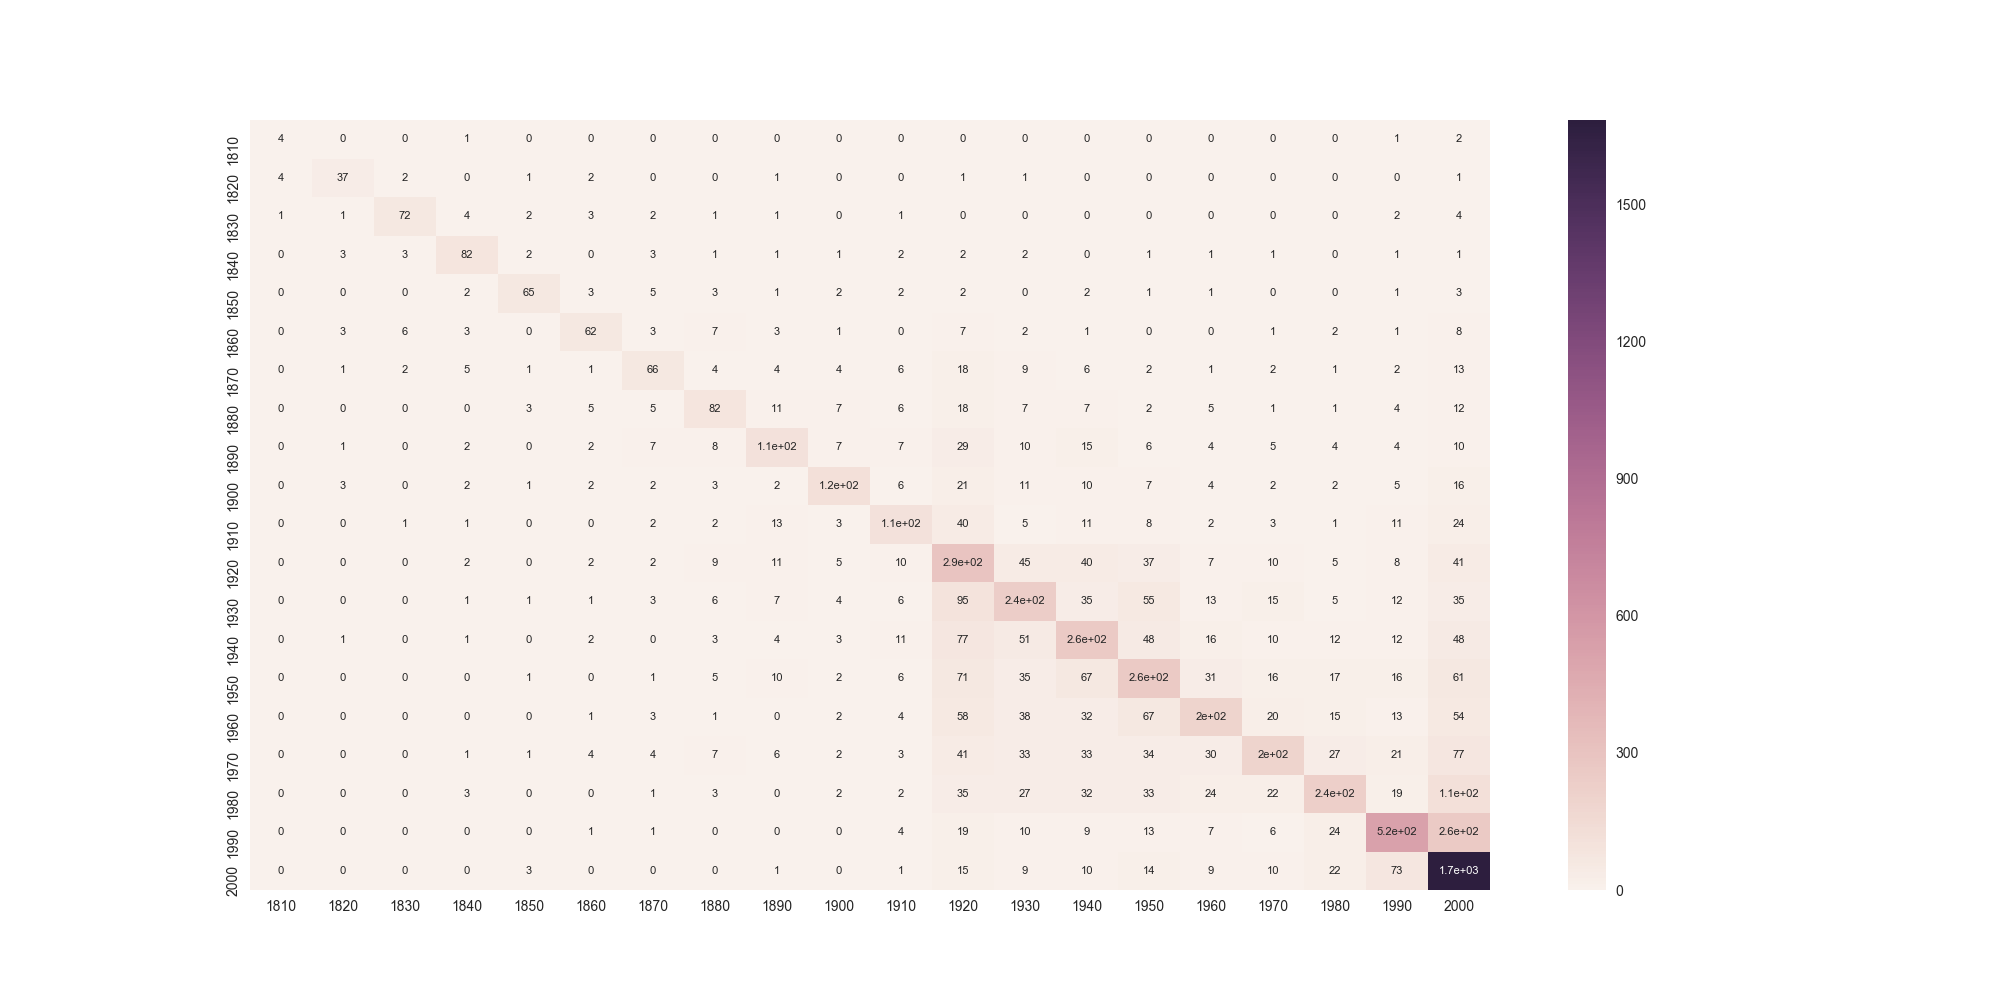

             precision    recall  f1-score   support

       1810       0.44      0.50      0.47         8
       1820       0.74      0.74      0.74        50
       1830       0.84      0.77      0.80        94
       1840       0.75      0.77      0.76       107
       1850       0.80      0.70      0.75        93
       1860       0.68      0.56      0.62       110
       1870       0.60      0.45      0.51       148
       1880       0.57      0.47      0.51       176
       1890       0.59      0.48      0.53       231
       1900       0.72      0.54      0.62       216
       1910       0.59      0.47      0.52       238
       1920       0.35      0.55      0.43       525
       1930       0.45      0.45      0.45       534
       1940       0.45      0.46      0.46       556
       1950       0.45      0.44      0.44       603
       1960       0.56      0.39      0.46       504
       1970       0.62      0.39      0.48       527
       1980       0.63      0.43      0.51   

In [29]:
eval_learner(coha_test['Decade'], RF_pred)

### SVM

In [16]:
SVM_clf = LinearSVC(random_state=0).fit(X_train, coha_train['Decade'])

In [17]:
SVM_pred = SVM_clf.predict(X_test)

<IPython.core.display.Javascript object>


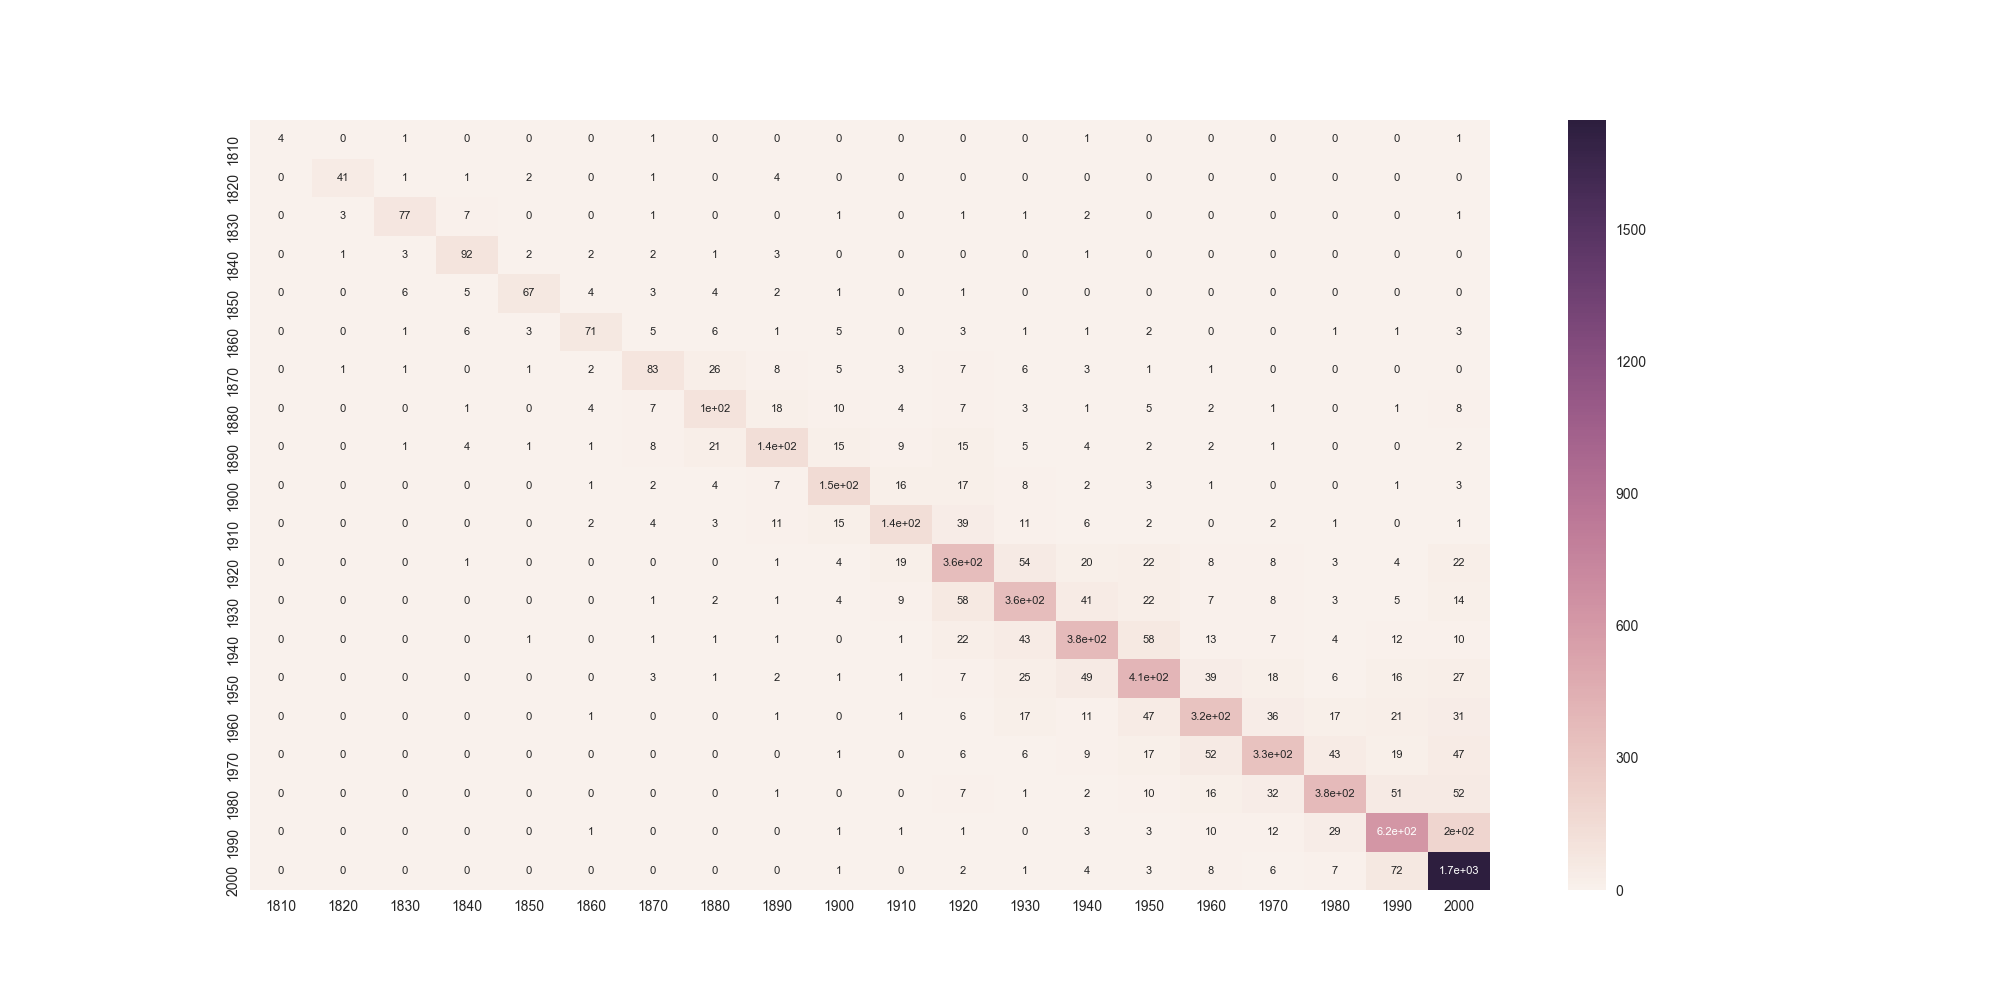

             precision    recall  f1-score   support

       1810       1.00      0.50      0.67         8
       1820       0.89      0.82      0.85        50
       1830       0.85      0.82      0.83        94
       1840       0.79      0.86      0.82       107
       1850       0.87      0.72      0.79        93
       1860       0.80      0.65      0.71       110
       1870       0.68      0.56      0.61       148
       1880       0.60      0.59      0.60       176
       1890       0.70      0.61      0.65       231
       1900       0.70      0.70      0.70       216
       1910       0.69      0.59      0.64       238
       1920       0.64      0.68      0.66       525
       1930       0.66      0.67      0.67       534
       1940       0.70      0.69      0.70       556
       1950       0.67      0.68      0.68       603
       1960       0.66      0.62      0.64       504
       1970       0.71      0.62      0.66       527
       1980       0.77      0.69      0.73   

In [18]:
eval_learner(coha_test['Decade'], SVM_pred)

#### Trigram

In [39]:
SVM_ngclf = LinearSVC(random_state=0).fit(X_train_ng, coha_train['Decade'])

In [40]:
SVM_ngpred = SVM_ngclf.predict(X_test_ng)

<IPython.core.display.Javascript object>


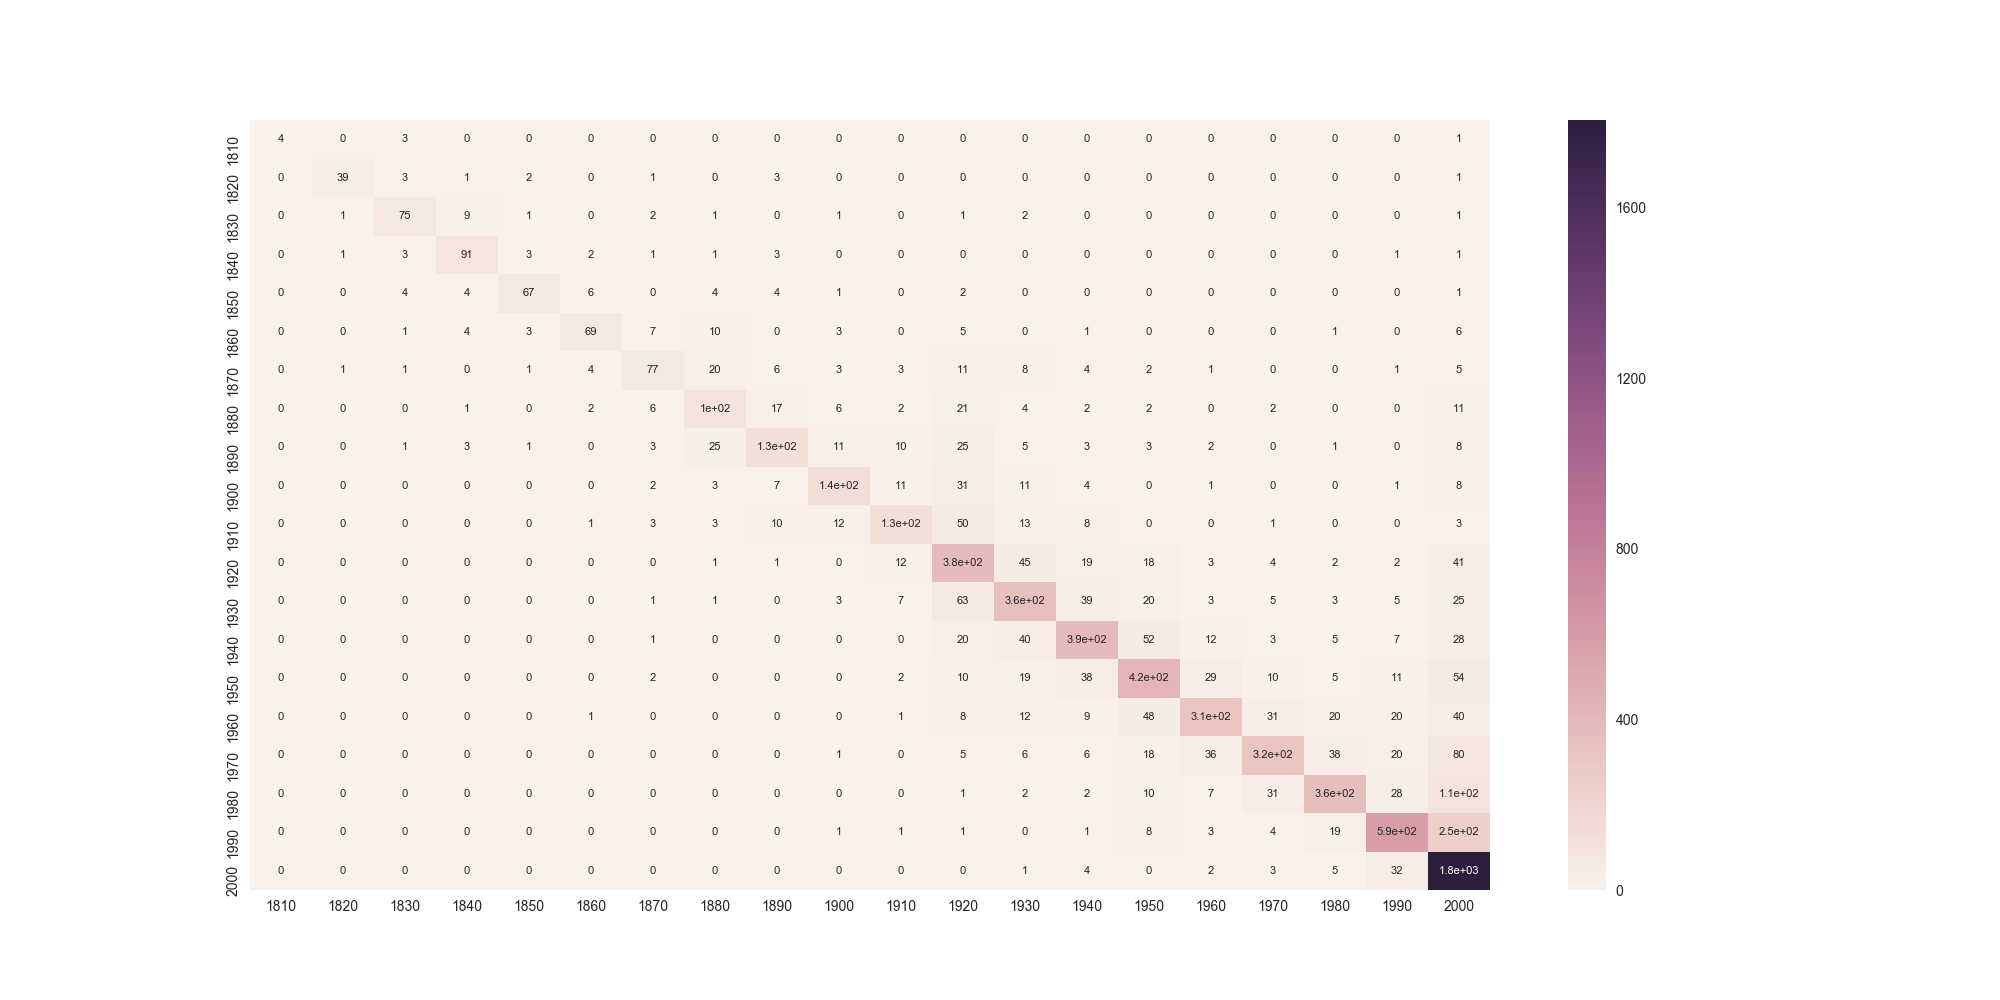

             precision    recall  f1-score   support

       1810       1.00      0.50      0.67         8
       1820       0.93      0.78      0.85        50
       1830       0.82      0.80      0.81        94
       1840       0.81      0.85      0.83       107
       1850       0.86      0.72      0.78        93
       1860       0.81      0.63      0.71       110
       1870       0.73      0.52      0.61       148
       1880       0.59      0.57      0.58       176
       1890       0.72      0.56      0.63       231
       1900       0.77      0.63      0.69       216
       1910       0.73      0.56      0.64       238
       1920       0.60      0.72      0.65       525
       1930       0.68      0.67      0.68       534
       1940       0.73      0.70      0.72       556
       1950       0.70      0.70      0.70       603
       1960       0.76      0.62      0.68       504
       1970       0.77      0.60      0.68       527
       1980       0.78      0.65      0.71   

In [41]:
eval_learner(coha_test['Decade'], SVM_ngpred)

# Refined Models

Given the preliminary results obtained earlier we now extend our implementations to include more practical model tuning.

To aid in our understanding of the problem space and the behavior of our models, it will be beneficial to plot the learning curves.  For convenience we will use the implementation of a learning curve plot generator from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py.

In [11]:
def plot_learning_curve(title, model, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## Improving SVM

As SVM was the best performing model in the first experiment, we will examine how close to optimal it was in the original COHA space.

First we will use grid search to find optimal parameters for SVM.

In [5]:
SVM_clf = GridSearchCV(LinearSVC(random_state=0), 
                      {'C': [.001, .01, .1, 1, 1.001, 1.01, 1.1, 1.15, 1.2, 1.5]}, 
                       scoring='neg_mean_absolute_error', 
                       n_jobs=1)
SVM_clf.fit(X_train, coha_train['Decade'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 1.001, 1.01, 1.1, 1.15, 1.2, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [8]:
print SVM_clf.best_estimator_

LinearSVC(C=1.15, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)


<IPython.core.display.Javascript object>


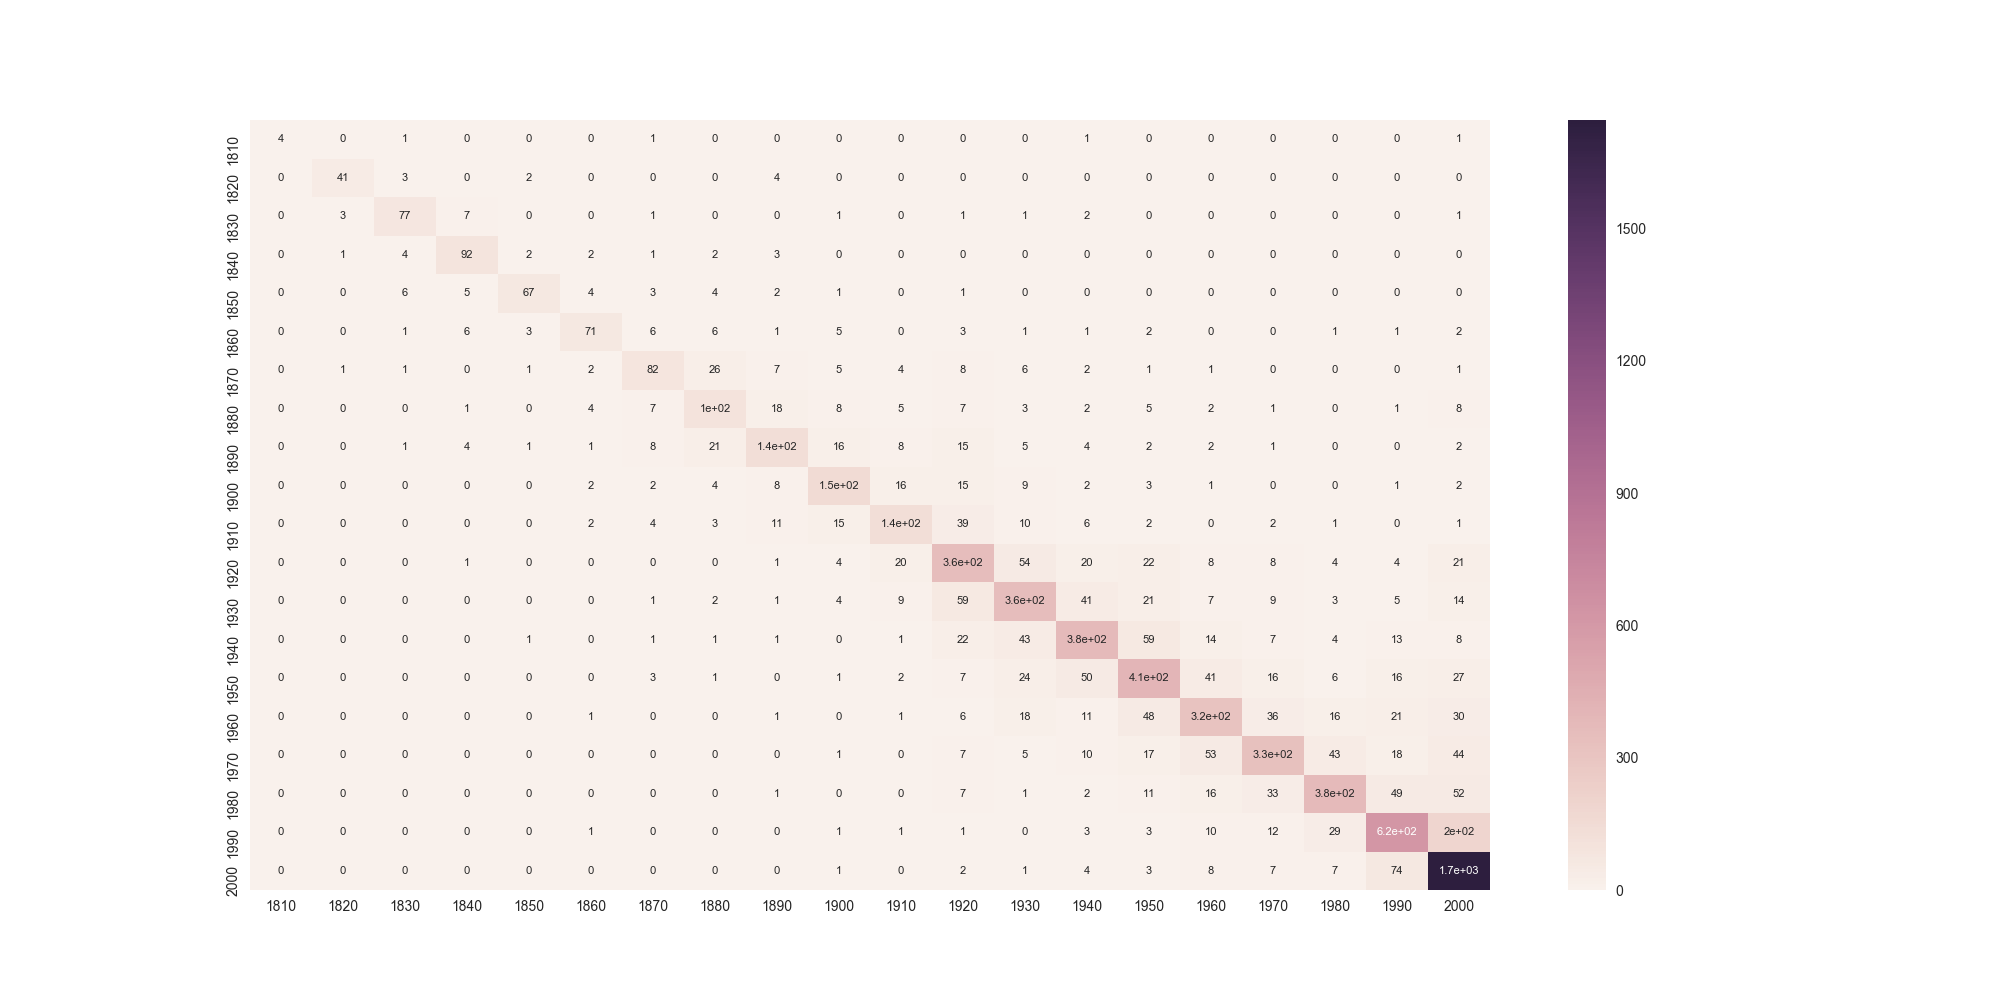

             precision    recall  f1-score   support

       1810       1.00      0.50      0.67         8
       1820       0.89      0.82      0.85        50
       1830       0.82      0.82      0.82        94
       1840       0.79      0.86      0.83       107
       1850       0.87      0.72      0.79        93
       1860       0.79      0.65      0.71       110
       1870       0.68      0.55      0.61       148
       1880       0.60      0.59      0.59       176
       1890       0.70      0.61      0.65       231
       1900       0.71      0.70      0.70       216
       1910       0.68      0.60      0.64       238
       1920       0.64      0.68      0.66       525
       1930       0.66      0.67      0.67       534
       1940       0.70      0.69      0.69       556
       1950       0.67      0.68      0.68       603
       1960       0.66      0.62      0.64       504
       1970       0.71      0.62      0.67       527
       1980       0.77      0.69      0.73   

In [9]:
SVM_pred = SVM_clf.predict(X_test)
eval_learner(coha_test['Decade'], SVM_pred)

Next let's plot the learning curve for SVM with the optimal hyperparameters.

<IPython.core.display.Javascript object>


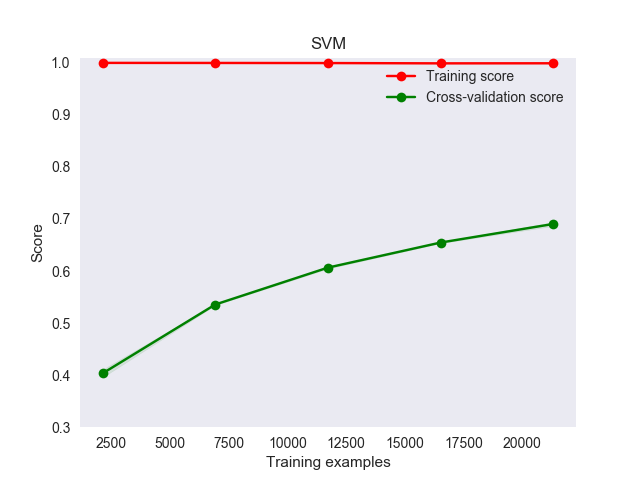

<module 'matplotlib.pyplot' from '/Users/heatherfrantz/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [12]:
plot_learning_curve('SVM', LinearSVC(C=1.15, random_state=0), X_train, coha_train['Decade'], (0.3, 1.01))

From this plot we see that our model may be able to generalize better given more data.  Having this in mind we will incorporate the New York Times dataset for training/test.

## Incorporating Other Corpora

We need to incorporate the NYT dataset which was aquired through the public API.  The data consists of snippets and leading paragraphs from news articles from 1850's-2000's.  Given that this data does not include any instance from pre-1850 we will also need to incorporate some of the Gutenberg data to offset this.

### New York Times

First we need to define our parsing interface.  It is similar to the parse_COHA method defined earlier, however we will now return the data as a list instead of as a DataFrame.

In [70]:
def parse_NYT(filename):
    data = []
    year = int(filename[:4])
    decade = int(filename[:3] + '0')
    
    with open('Data/New York Times/' + filename, 'r') as f:
        samples = f.read().split('\n')[:-1]  # Ignore final newline
    
    # Ignore short snippets
    for sample in samples:
        if len(sample) > 10:
            data.append((year, sample, decade, len(sample)))
    
    return data

Next we will parse our data records from the years 1851-2002.

In [71]:
NYT_data = []

for year in range(1851, 2003):
    NYT_data = NYT_data + parse_NYT(str(year) + '.txt')

Now we can store our data into a DataFrame.

In [72]:
NYT_data = pd.DataFrame(NYT_data, columns=['Year', 'Text', 'Decade', 'Length'])

We will do some exploratory analysis of the NYT dataset to see how best to incorporate the data into COHA without polluting the frequency balance.

Year Coverage Statistics:
    Max: 3247
    Min: 805
    Mean: 2037.09210526
    Std: 536.748740104
    Median: 1971.0

Complete Year Distribution:
1851    1465
1852    1217
1853    1318
1854    1181
1855    1255
1856    1235
1857    1548
1858    1520
1859    1221
1860     924
1861     995
1862    1177
1863    1649
1864    1443
1865    1884
1866    2112
1867    1899
1868    2034
1869    2088
1870    1970
1871    1686
1872    1937
1873    1953
1874    1941
1875    1808
1876    2237
1877    1673
1878    1963
1879    1660
1880     805
1881    1708
1882    2089
1883    1083
1884    1757
1885    2321
1886    2375
1887    2440
1888    2390
1889    2392
1890     838
1891    1827
1892    1677
1893    2475
1894    2638
1895    1737
1896    1904
1897    1682
1898    1491
1899    1249
1900    1199
1901    1331
1902    1341
1903    1482
1904    1793
1905    1763
1906    1558
1907    1713
1908    1621
1909    2216
1910    1974
1911    2218
1912    2173
1913    2367
1914    2618
1915    2202
1916   

<IPython.core.display.Javascript object>


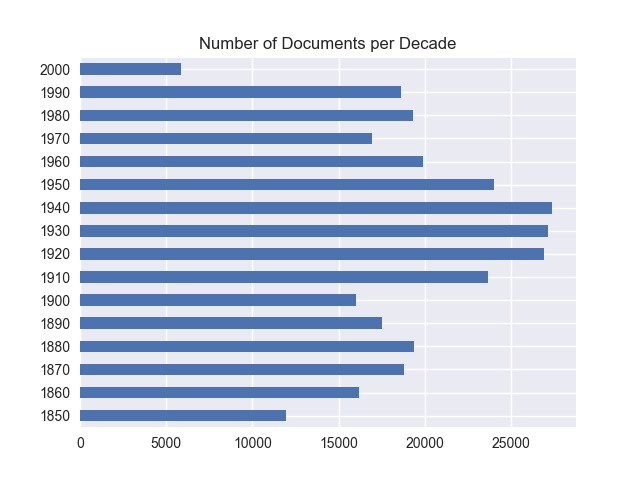

In [73]:
analyze_corpus_data(NYT_data)

We see from the above analysis that the number of documents is relatively balanced between all decade classes.  This is a pleasant surprise.

Text Frequency Statistics:

Total:
Decade
1850    2471284
1860    2625698
1870    2195329
1880    3273206
1890    2372511
1900    2357565
1910    3008868
1920    3118305
1930    3097736
1940    3003012
1950    2821992
1960    3277755
1970    6480775
1980    4548125
1990    5298490
2000    2143606
Name: Length, dtype: int64

Max:
Decade
1850     247
1860    1054
1870     247
1880     247
1890     255
1900     398
1910     870
1920     624
1930     699
1940     654
1950     897
1960    1307
1970    3079
1980    1496
1990    1763
2000    1866
Name: Length, dtype: int64

Min:
Decade
1850    11
1860    11
1870    11
1880    11
1890    11
1900    11
1910    11
1920    11
1930    11
1940    11
1950    11
1960    11
1970    14
1980    11
1990    11
2000    11
Name: Length, dtype: int64

Mean:
Decade
1850    206.629097
1860    162.030114
1870    116.599161
1880    169.070558
1890    135.432755
1900    147.191422
1910    127.090517
1920    115.840299
1930    114.139130
1940    109.558993
1950   

<IPython.core.display.Javascript object>


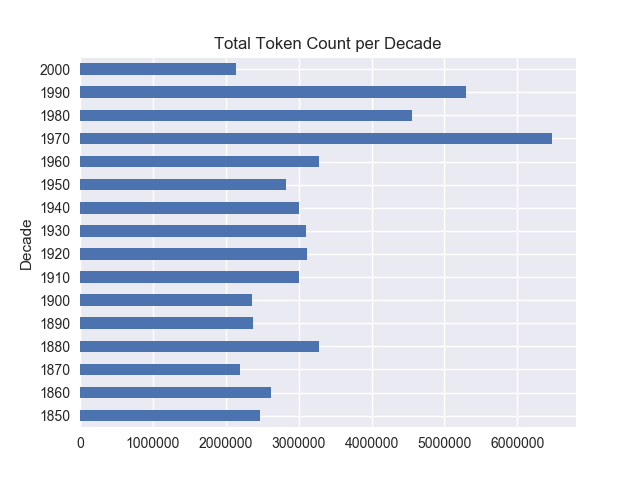

In [74]:
analyze_text(NYT_data)

We see that the word frequency is also relatively balanced amoung all decades with 1970-1990 having longer documents than the rest.

Next let us combine COHA and NYT to see the total data statistics.

In [75]:
coha_full['Corpus'] = 'COHA'
NYT_data['Corpus'] = 'NYT'

In [78]:
coha_NYT_data = pd.concat([coha_full, NYT_data])

As usual let's save our dataset for future use.

In [86]:
coha_NYT_data.to_pickle('coha_NYT.pkl')

In [ ]:
coha_NYT_data = pd.read_pickle('coha_NYT.pkl')

We can now analyze the year/decade coverage statistics.

Year Coverage Statistics:
    Max: 3247
    Min: 1
    Mean: 993.289772727
    Std: 989.948751793
    Median: 320.0

Complete Year Distribution:
1851    1465
1852    1217
1853    1318
1854    1181
1855    1255
1856    1235
1857    1548
1858    1520
1859    1221
1860     924
1861     995
1862    1177
1863    1649
1864    1443
1865    1884
1866    2112
1867    1899
1868    2034
1869    2088
1870    1970
1871    1686
1872    1937
1873    1953
1874    1941
1875    1808
1876    2237
1877    1673
1878    1963
1879    1660
1880     805
1881    1708
1882    2089
1883    1083
1884    1757
1885    2321
1886    2375
1887    2440
1888    2390
1889    2392
1890     838
1891    1827
1892    1677
1893    2475
1894    2638
1895    1737
1896    1904
1897    1682
1898    1491
1899    1249
1900    1199
1901    1331
1902    1341
1903    1482
1904    1793
1905    1763
1906    1558
1907    1713
1908    1621
1909    2216
1910    1974
1911    2218
1912    2173
1913    2367
1914    2618
1915    2202
1916    28

<IPython.core.display.Javascript object>


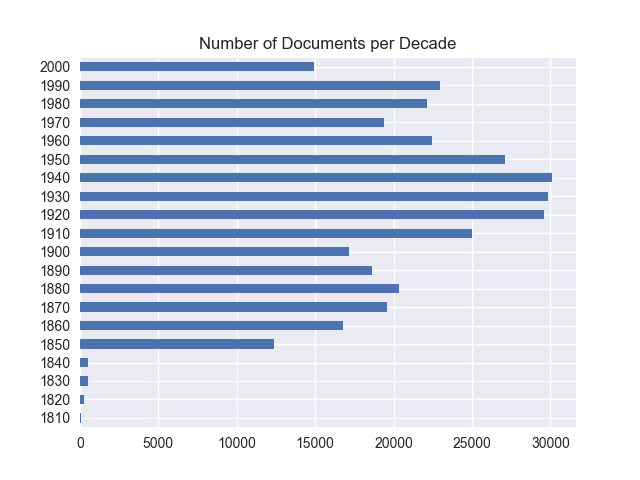

In [84]:
analyze_corpus_data(coha_NYT_data)

Next we will visualize the text frequency per decade.

Text Frequency Statistics:

Total:
Decade
1810     2866316
1820     9496850
1830    21853319
1840    23512631
1850    26847456
1860    22243186
1870    26448331
1880    28692696
1890    26989685
1900    28720276
1910    31261961
1920    29116159
1930    29834890
1940    28893461
1950    29883998
1960    28642970
1970    32692020
1980    34812807
1990    35057322
2000    32602599
Name: Length, dtype: int64

Max:
Decade
1810    227155
1820    160380
1830    252998
1840    364780
1850    251887
1860    255796
1870    213229
1880    191478
1890    200410
1900    240932
1910    210337
1920    213193
1930    245479
1940    213128
1950    207824
1960    176500
1970    302613
1980    294180
1990    141824
2000     60408
Name: Length, dtype: int64

Min:
Decade
1810    216
1820    197
1830    180
1840      1
1850      0
1860     11
1870      1
1880     11
1890     11
1900     11
1910     11
1920     11
1930     11
1940     11
1950     11
1960     11
1970     14
1980     11
1990      7
2000      

<IPython.core.display.Javascript object>


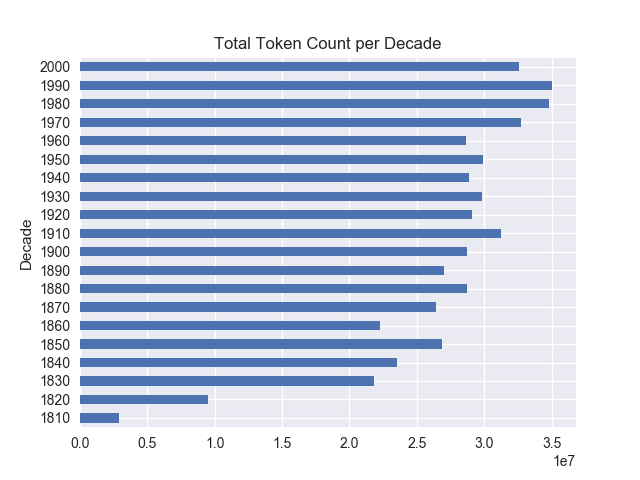

In [85]:
analyze_text(coha_NYT_data)

We can see that the COHA + NYT data is fairly imbalanced.  In any case, it will be interesting to train an SVM on this new dataset and see how the performance compares to before.

### COHA + NYT SVM

First we will do an 80/20 train/test split.

In [87]:
coha_NYT_train, coha_NYT_test = train_test_split(coha_NYT_data, test_size=0.2)
coha_NYT_train.to_pickle('coha_NYT_train.pkl')
coha_NYT_test.to_pickle('coha_NYT_test.pkl')

In [ ]:
coha_NYT_train = pd.read_pickle('coha_NYT_train.pkl')
coha_NYT_test = pd.read_pickle('coha_NYT_test.pkl')

Next we need to extract our features.

In [91]:
vectorizer = CountVectorizer(stop_words='english')
transformer = TfidfTransformer()
X_train_counts = vectorizer.fit_transform(coha_NYT_train['Text'])
X_train = transformer.fit_transform(X_train_counts)

In [92]:
X_test_counts = vectorizer.transform(coha_NYT_test['Text'])
X_test = transformer.transform(X_test_counts)

Save the features for later use.

In [93]:
pickle.dump(X_train, open("coha_BoW_train.pkl", "wb"))
pickle.dump(X_test, open("coha_BoW_test.pkl", "wb"))

In [ ]:
X_train = pickle.load(open("coha_BoW_train.pkl", "rb"))
X_test = pickle.load(open("coha_BoW_test.pkl", "rb"))

Now we can plot the learning curve for SVM to see what impact our additional data had on the model

<IPython.core.display.Javascript object>


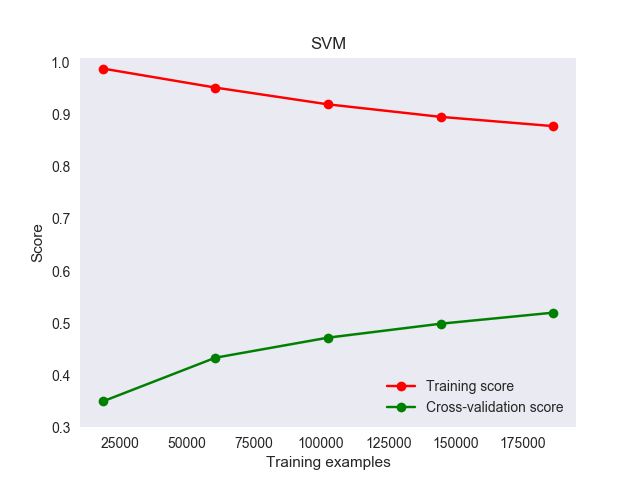

<module 'matplotlib.pyplot' from '/Users/heatherfrantz/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [94]:
plot_learning_curve('SVM', LinearSVC(C=1.15, random_state=0), X_train, coha_NYT_train['Decade'], (0.3, 1.01))

In [95]:
SVM_clf = LinearSVC(random_state=0).fit(X_train, coha_NYT_train['Decade'])

<IPython.core.display.Javascript object>


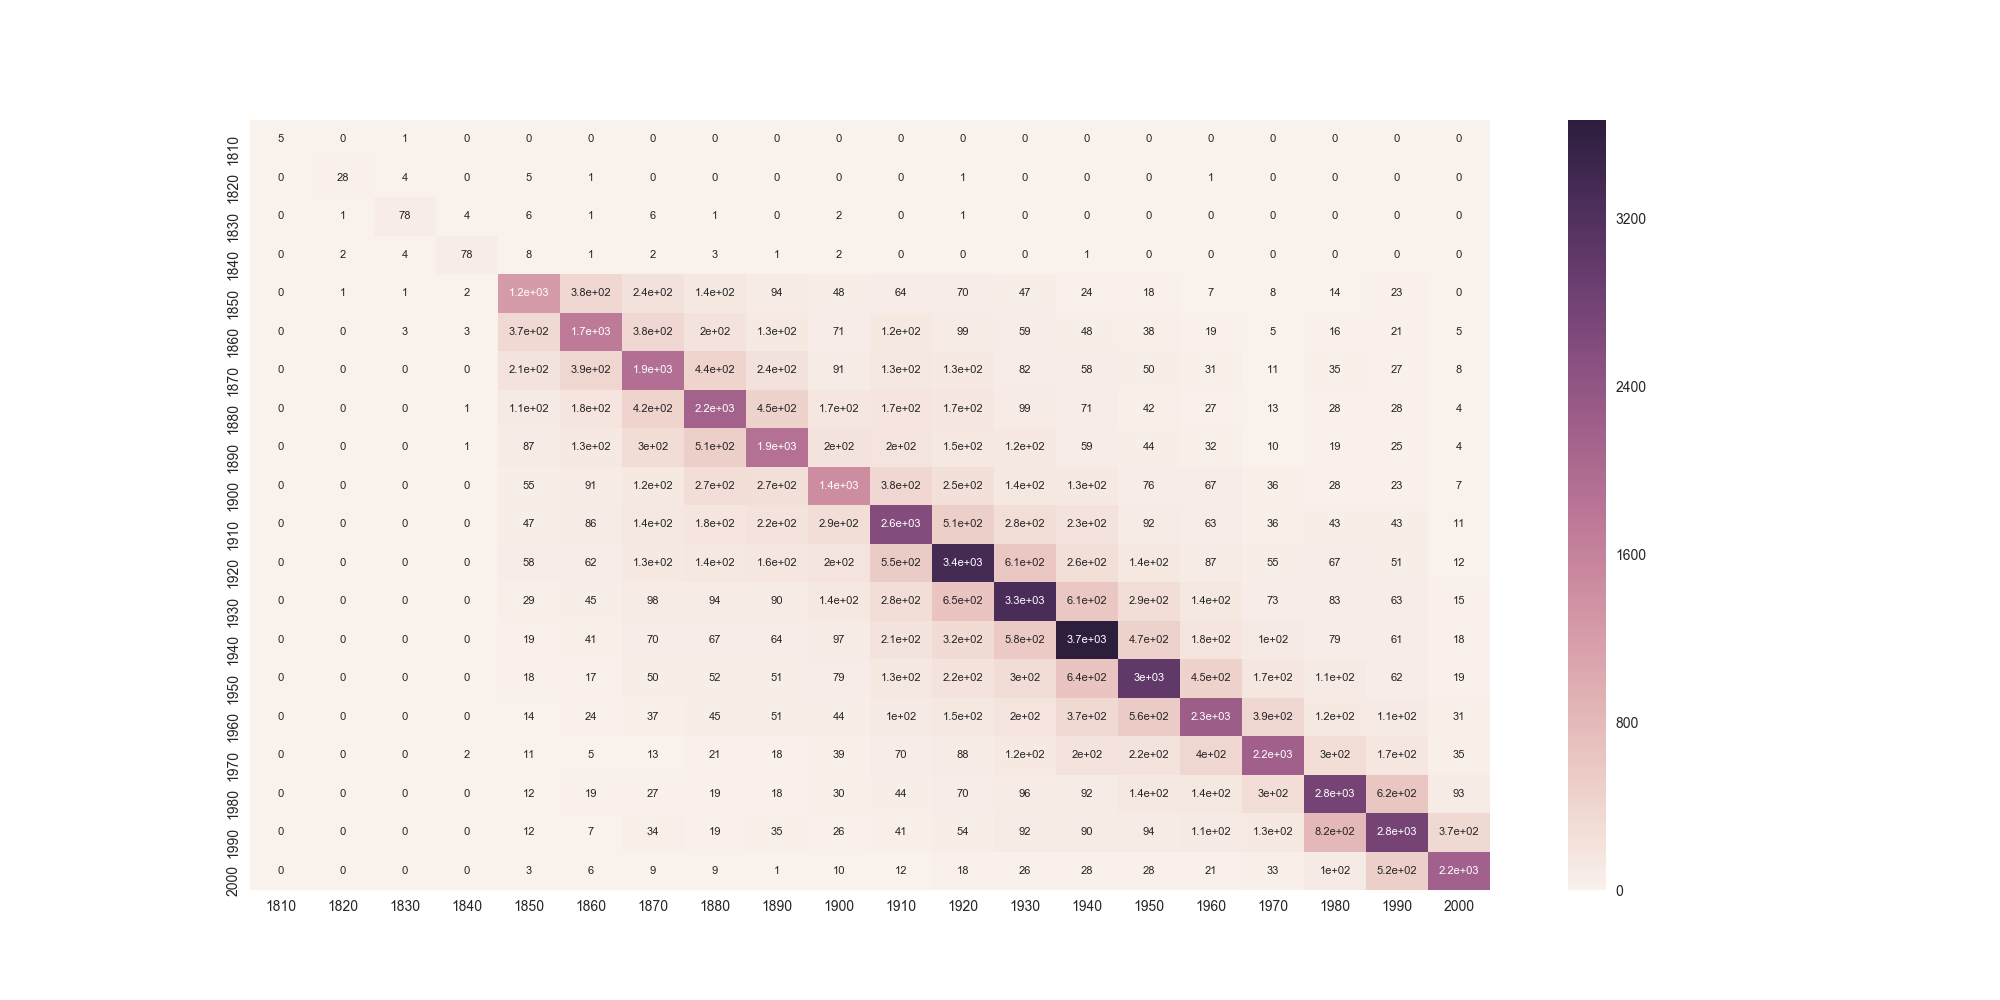

             precision    recall  f1-score   support

       1810       1.00      0.83      0.91         6
       1820       0.88      0.70      0.78        40
       1830       0.86      0.78      0.82       100
       1840       0.86      0.76      0.81       102
       1850       0.54      0.52      0.53      2418
       1860       0.54      0.52      0.53      3307
       1870       0.48      0.50      0.49      3871
       1880       0.49      0.52      0.51      4133
       1890       0.50      0.50      0.50      3765
       1900       0.48      0.42      0.45      3383
       1910       0.51      0.53      0.52      4854
       1920       0.53      0.57      0.55      5937
       1930       0.54      0.55      0.54      6007
       1940       0.56      0.61      0.58      6043
       1950       0.57      0.56      0.56      5381
       1960       0.56      0.50      0.53      4495
       1970       0.62      0.56      0.59      3912
       1980       0.60      0.62      0.61   

In [96]:
SVM_pred = SVM_clf.predict(X_test)
eval_learner(coha_NYT_test['Decade'], SVM_pred)

We see that by incorporating the NYT data the problem has become much harder to model.  Let's try hyperparameter tuning to get better results.

In [112]:
SVM_clf = GridSearchCV(LinearSVC(random_state=0), 
                      {'C': [.25, .35, .55, .75, .9, 1]}, 
                       scoring='neg_mean_absolute_error', 
                       n_jobs=1)
SVM_clf.fit(X_train, coha_NYT_train['Decade'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.25, 0.35, 0.55, 0.75, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [113]:
print SVM_clf.best_estimator_

LinearSVC(C=0.35, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)


<IPython.core.display.Javascript object>


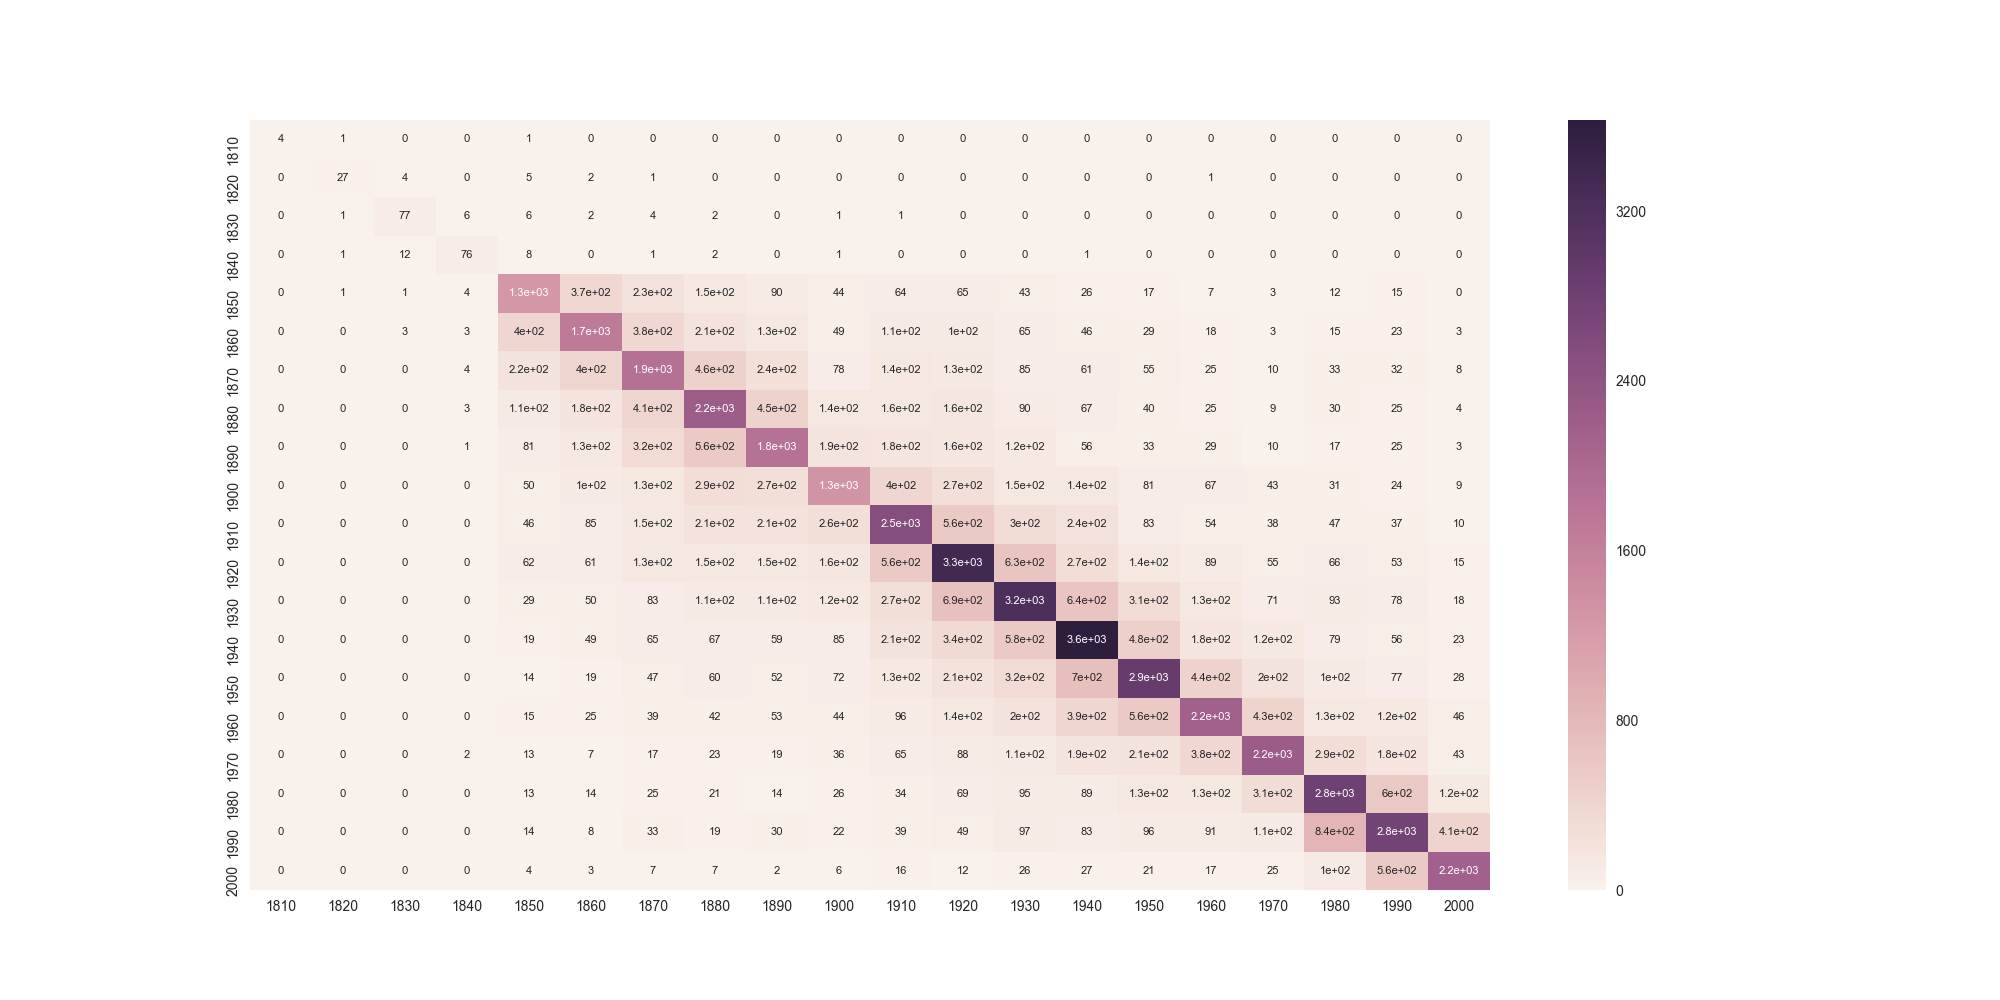

             precision    recall  f1-score   support

       1810       1.00      0.67      0.80         6
       1820       0.87      0.68      0.76        40
       1830       0.79      0.77      0.78       100
       1840       0.77      0.75      0.76       102
       1850       0.53      0.53      0.53      2418
       1860       0.53      0.52      0.53      3307
       1870       0.48      0.49      0.48      3871
       1880       0.48      0.54      0.51      4133
       1890       0.50      0.49      0.49      3765
       1900       0.50      0.39      0.44      3383
       1910       0.51      0.52      0.51      4854
       1920       0.52      0.56      0.54      5937
       1930       0.53      0.53      0.53      6007
       1940       0.55      0.60      0.57      6043
       1950       0.56      0.54      0.55      5381
       1960       0.56      0.48      0.52      4495
       1970       0.61      0.57      0.59      3912
       1980       0.60      0.62      0.61   

In [114]:
SVM_pred = SVM_clf.predict(X_test)
eval_learner(coha_NYT_test['Decade'], SVM_pred)